AI MODEL TRAIN NOTEBOOK WITH SPOTIFY AUDIO FEATURES

In [12]:
import pandas as pd
import json

# Load audio features from JSON file
with open('audio_features.json') as file:  # Replace 'audio_features.json' with the actual file name
    data = json.load(file)

# Convert JSON data to DataFrame
df_audio_features = pd.DataFrame(data)

# Display the first few rows to confirm it loaded correctly
print(df_audio_features.head())

                 track_id  acousticness  danceability  energy  \
0  34KTEhpPjq6IAgQg2yzJAL        0.0021         0.592   0.767   
1  1og0kGjsNTWB5gnVcxbqb3        0.8420         0.542   0.303   
2  7eLCcnhpYGH3Y6Pqrk68Gz        0.0320         0.657   0.611   
3  0uexBOVPB278fGFOxOUosN        0.3120         0.781   0.877   
4  0NRdCItA8w9eB7MOcprHVi        0.6540         0.625   0.351   

   instrumentalness  liveness  loudness  speechiness  valence       tempo  \
0           0.00165    0.1270    -2.788       0.0270    0.328   96.483002   
1           0.00000    0.0853   -10.229       0.0293    0.231  115.194000   
2           0.00000    0.4690    -7.899       0.4910    0.408  140.151001   
3           0.00000    0.3700    -5.761       0.0377    0.781  108.066002   
4           0.37100    0.1960   -13.338       0.0489    0.205  115.495003   

   track_key  mode  time_signature  
0          9     0               4  
1          7     1               4  
2          1     1               5 

In [13]:
print(len(df_audio_features))

10000


In [14]:
# Generate sample mood labels to match the DataFrame length
# Relevant features for mood classification
features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
X = df_audio_features[features]

moods = ['happy', 'sad', 'energetic', 'calm']
df_audio_features['mood'] = [moods[i % len(moods)] for i in range(len(df_audio_features))]

X = df_audio_features.select_dtypes(include=['number'])

# If you have a 'mood' column as your target variable, separate it
y = df_audio_features['mood'] if 'mood' in df_audio_features.columns else None

# Check the resulting DataFrame
print(X.head())

   acousticness  danceability  energy  instrumentalness  liveness  loudness  \
0        0.0021         0.592   0.767           0.00165    0.1270    -2.788   
1        0.8420         0.542   0.303           0.00000    0.0853   -10.229   
2        0.0320         0.657   0.611           0.00000    0.4690    -7.899   
3        0.3120         0.781   0.877           0.00000    0.3700    -5.761   
4        0.6540         0.625   0.351           0.37100    0.1960   -13.338   

   speechiness  valence       tempo  track_key  mode  time_signature  
0       0.0270    0.328   96.483002          9     0               4  
1       0.0293    0.231  115.194000          7     1               4  
2       0.4910    0.408  140.151001          1     1               5  
3       0.0377    0.781  108.066002          2     0               4  
4       0.0489    0.205  115.495003          1     0               4  


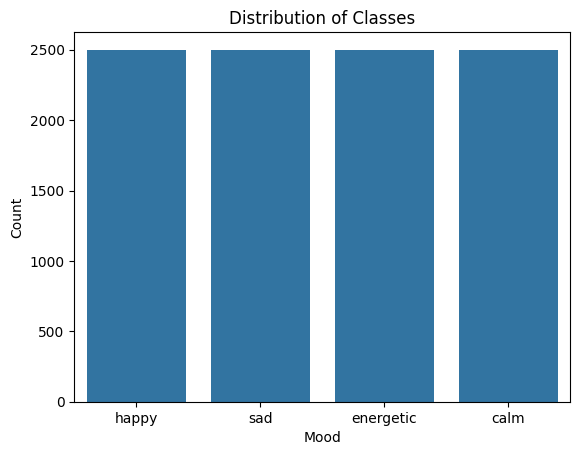

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of mood classes
sns.countplot(x=y)
plt.title("Distribution of Classes")
plt.xlabel("Mood")
plt.ylabel("Count")
plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

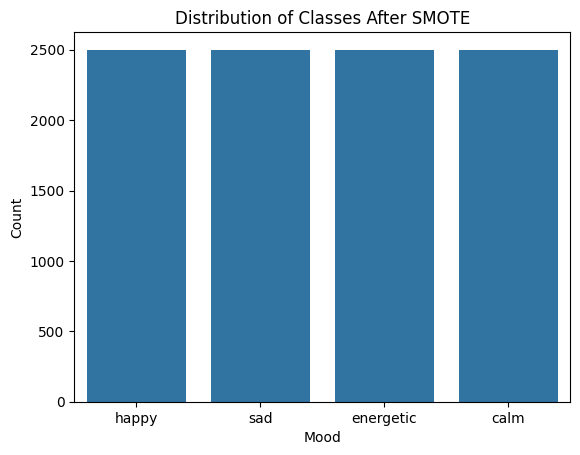

In [17]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check the new distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Distribution of Classes After SMOTE")
plt.xlabel("Mood")
plt.ylabel("Count")
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier and GridSearchCV
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [20]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with the best model
cross_val_scores = cross_val_score(best_rf_model, X_scaled, y, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", cross_val_scores.mean())


Cross-validation scores: [0.2415 0.2555 0.2555 0.2345 0.2545]
Average cross-validation score: 0.24829999999999997


In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.2375
Classification Report:
               precision    recall  f1-score   support

        calm       0.24      0.28      0.26       497
   energetic       0.24      0.25      0.25       527
       happy       0.24      0.19      0.21       480
         sad       0.23      0.23      0.23       496

    accuracy                           0.24      2000
   macro avg       0.24      0.24      0.24      2000
weighted avg       0.24      0.24      0.24      2000



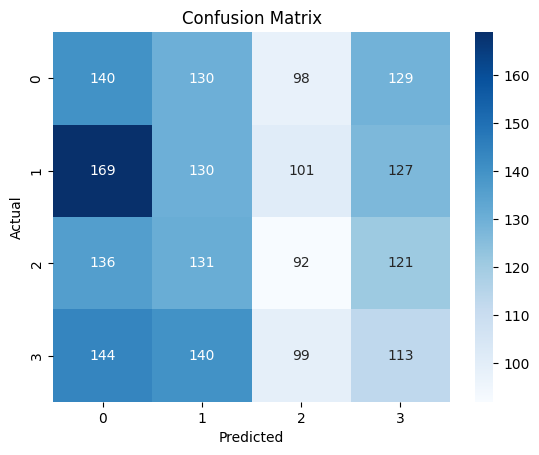

In [23]:
from sklearn.metrics import confusion_matrix

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
